In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/COMP 8740/Sensorless drive/'
%ls

/content/drive/.shortcut-targets-by-id/1JUQsPh8USkoDSejstcM_Ha7mEf5CLIRH/COMP 8740/Sensorless drive
 Extra/             Final_2_Results/  'Old Final'/
 Final_1.ipynb      Final_3.ipynb      Sensorless_drive_diagnosis.txt
 Final_1_Results/   Final_3_Results/
 Final_2.ipynb      Final_Scripts/


In [3]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif

In [4]:
col_names = [f'feat{i+1}' for i in range(48)] + ['class']
df = pd.read_csv('Sensorless_drive_diagnosis.txt', header=None, names=col_names, sep=' ')
le = LabelEncoder()
df['class_enc'] = le.fit_transform(df['class'])
target_names = [str(c) for c in le.classes_]

In [5]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [6]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [7]:
unique_test_labels = np.unique(y_test)

In [8]:
reduced_datasets = {}

In [9]:
rfe = RFE(LogisticRegression(solver='lbfgs', random_state=42, max_iter=10000), n_features_to_select=20)
rfe.fit(X_train_scaled, y_train)
sel_rfe = X_train_scaled.columns[rfe.support_]
reduced_datasets['RFE_LR'] = {
    'X_train_reduced': X_train_scaled[sel_rfe],
    'X_test_reduced': X_test_scaled[sel_rfe]
}

In [10]:
skb_c = SelectKBest(f_classif, k=20)
skb_c.fit(X_train_scaled, y_train)
sel_skb = X_train_scaled.columns[skb_c.get_support()]
reduced_datasets['SKB_Classif'] = {
    'X_train_reduced': X_train_scaled[sel_skb],
    'X_test_reduced': X_test_scaled[sel_skb]
}

In [11]:
skb_m = SelectKBest(mutual_info_classif, k=20)
skb_m.fit(X_train_scaled, y_train)
sel_skb = X_train_scaled.columns[skb_m.get_support()]
reduced_datasets['SKB_Mtl_Classif'] = {
    'X_train_reduced': X_train_scaled[sel_skb],
    'X_test_reduced': X_test_scaled[sel_skb]
}

Variance explained by first 20 components: 0.9508


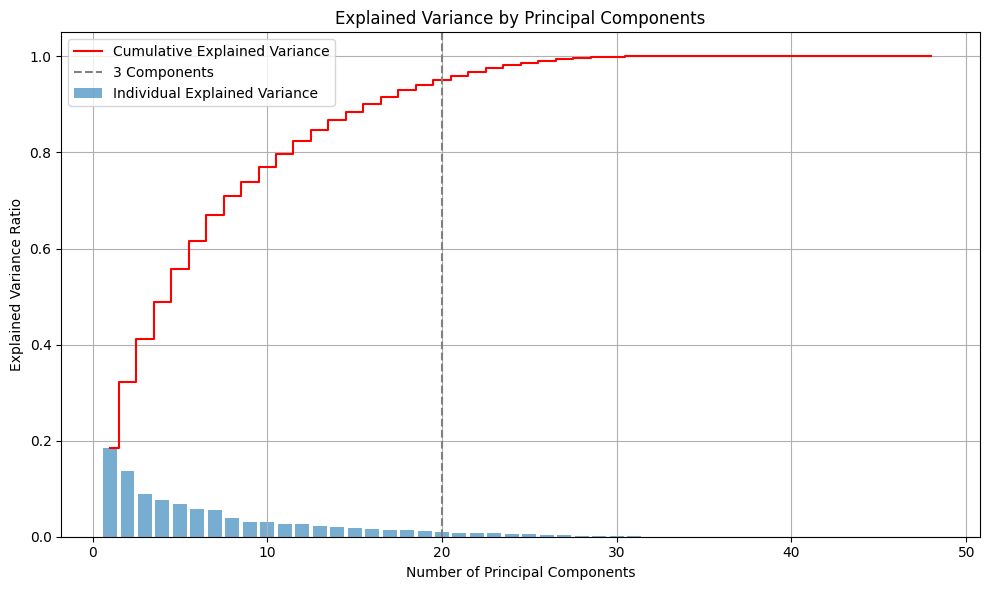

In [12]:
pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(f"Variance explained by first 20 components: {cumulative_variance[19]:.4f}")

plt.figure(figsize=(10, 6))

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance', color='red')

plt.axvline(20, color='gray', linestyle='--', label='3 Components')

plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

reduced_datasets['PCA'] = {
    'X_train_reduced': X_train_pca,
    'X_test_reduced': X_test_pca
}
print("Components retained:", pca.n_components_)

Components retained: 20


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
scoring = {'accuracy': 'accuracy'}

all_results_lr = []
test_metrics = []

for kk in list(reduced_datasets.keys()):
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    X_test_reduced = reduced_datasets[kk]['X_test_reduced']
    model = LogisticRegression(max_iter=10000, random_state=42)
    grid_search = GridSearchCV(model, param_grid_lr, scoring=scoring,
        refit='accuracy', cv=3, return_train_score=True, n_jobs=-1, verbose=2)

    grid_search.fit(X_train_reduced, y_train)
    print(f"Best params for k={kk}: {grid_search.best_params_}")

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['param_k'] = kk
    all_results_lr.append(results_df)

    y_pred = grid_search.predict(X_test_reduced)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    test_metrics.append({
        'param_k': kk,
        'test_accuracy': acc,
        'test_precision': prec,
        'test_recall': rec,
        'test_f1': f1
    })

combined_results_lr_df = pd.concat(all_results_lr, ignore_index=True)
test_metrics_lr_df = pd.DataFrame(test_metrics)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for k=RFE_LR: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for k=SKB_Classif: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for k=SKB_Mtl_Classif: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for k=PCA: {'C': 10, 'solver': 'lbfgs'}


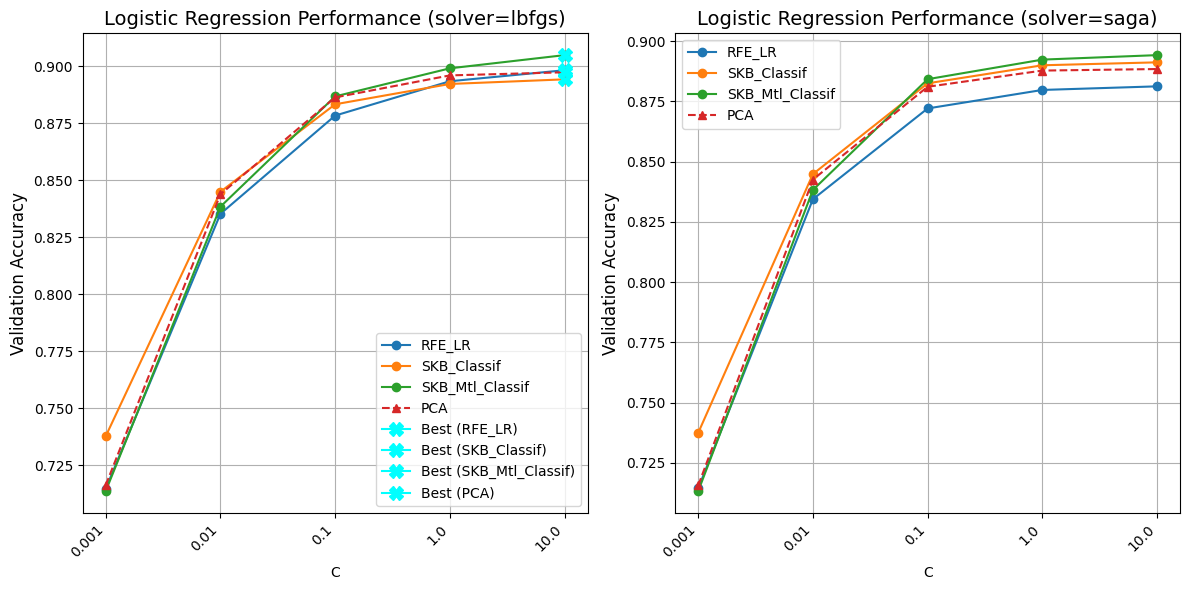

In [22]:
combined_results_lr_df['param_combination'] = (
    combined_results_lr_df['param_C'].astype(str) + " | " + combined_results_lr_df['param_solver']
)

results_lr_lbfgs = combined_results_lr_df[combined_results_lr_df['param_solver'] == 'lbfgs'].copy()
results_lr_saga = combined_results_lr_df[combined_results_lr_df['param_solver'] == 'saga'].copy()

results_lr_lbfgs['param_combination'] = results_lr_lbfgs['param_combination'].apply(lambda x: x.split(' | ')[0])
results_lr_saga['param_combination'] = results_lr_saga['param_combination'].apply(lambda x: x.split(' | ')[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k in combined_results_lr_df['param_k'].unique():
    subset_all = combined_results_lr_df[combined_results_lr_df['param_k'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_lbfgs = results_lr_lbfgs[results_lr_lbfgs['param_k'] == k]
    if k == 'PCA':
        ax1.plot(subset_lbfgs['param_combination'], subset_lbfgs['mean_test_accuracy'], marker='^', linestyle='--', label=f'{k}')
    else:
        ax1.plot(subset_lbfgs['param_combination'], subset_lbfgs['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_solver'] == 'lbfgs':
        ax1.plot(str(best_row['param_C']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax1.set_title('Logistic Regression Performance (solver=lbfgs)', fontsize=14)
    ax1.set_xlabel('C', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
    ax1.legend()
    ax1.grid(True)

    subset_saga = results_lr_saga[results_lr_saga['param_k'] == k]
    if k == 'PCA':
        ax2.plot(subset_saga['param_combination'], subset_saga['mean_test_accuracy'], marker='^', linestyle='--', label=f'{k}')
    else:
        ax2.plot(subset_saga['param_combination'], subset_saga['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_solver'] == 'saga':
        ax2.plot(str(best_row['param_C']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax2.set_title('Logistic Regression Performance (solver=saga)', fontsize=14)
    ax2.set_xlabel('C', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()
plt.show()

In [25]:
combined_results_lr_df.to_csv('Final_Scripts/Final2/GS_LR.csv', index=0)
test_metrics_lr_df.to_csv('Final_Scripts/Final2/Test_LR.csv', index=0)

In [26]:
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}
scoring = {'accuracy': 'accuracy'}

all_results_dt = []
test_metrics_dt = []

for kk in list(reduced_datasets.keys()):
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    X_test_reduced = reduced_datasets[kk]['X_test_reduced']
    model = DecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(model, param_grid_dt, scoring=scoring, refit='accuracy', cv=3, return_train_score=True, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_reduced, y_train)
    print(f"Best params for k={kk}: {grid_search.best_params_}")
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['param_k'] = kk
    all_results_dt.append(results_df)

    y_pred = grid_search.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    test_metrics_dt.append({
        'param_k': kk,
        'test_accuracy': acc,
        'test_precision': prec,
        'test_recall': rec,
        'test_f1': f1
    })

combined_results_dt_df = pd.concat(all_results_dt, ignore_index=True)
test_metrics_dt_df = pd.DataFrame(test_metrics_dt)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for k=RFE_LR: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for k=SKB_Classif: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for k=SKB_Mtl_Classif: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for k=PCA: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


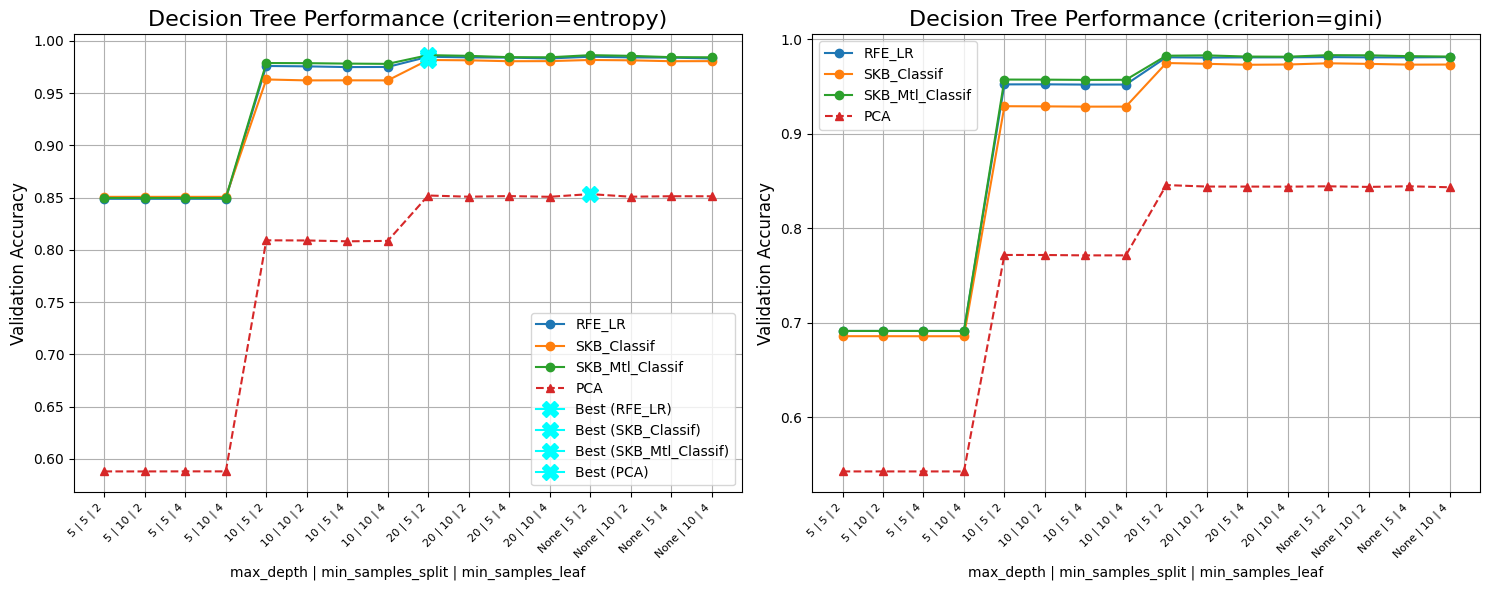

In [29]:
combined_results_dt_df['param_combination'] = (
    combined_results_dt_df['param_max_depth'].astype(str) + " | " + combined_results_dt_df['param_min_samples_split'].astype(str) + " | " + combined_results_dt_df['param_min_samples_leaf'].astype(str) + " | " +
    combined_results_dt_df['param_criterion'].astype(str))

results_dt_e1 = combined_results_dt_df[combined_results_dt_df['param_criterion'] == 'entropy'].copy()
results_dt_e2 = combined_results_dt_df[combined_results_dt_df['param_criterion'] == 'gini'].copy()

results_dt_e1['param_combination'] = results_dt_e1['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))
results_dt_e2['param_combination'] = results_dt_e2['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for k in combined_results_dt_df['param_k'].unique():
    subset_all = combined_results_dt_df[combined_results_dt_df['param_k'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_e1 = results_dt_e1[results_dt_e1['param_k'] == k]
    if k == 'PCA':
        ax1.plot(subset_e1['param_combination'], subset_e1['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax1.plot(subset_e1['param_combination'], subset_e1['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_criterion'] == 'entropy':
        best_comb = ' | '.join([str(best_row['param_max_depth']), str(best_row['param_min_samples_split']), str(best_row['param_min_samples_leaf'])])
        if best_comb in subset_e1['param_combination'].values:
            ax1.plot(best_comb, best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=12, label=f'Best ({k})')

    ax1.set_title('Decision Tree Performance (criterion=entropy)', fontsize=16)
    ax1.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
        x_tick.set_fontsize(8)
    ax1.legend()
    ax1.grid(True)

    subset_e2 = results_dt_e2[results_dt_e2['param_k'] == k]
    if k == 'PCA':
        ax2.plot(subset_e2['param_combination'], subset_e2['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax2.plot(subset_e2['param_combination'], subset_e2['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_criterion'] == 'gini':
        best_comb = ' | '.join([str(best_row['param_max_depth']), str(best_row['param_min_samples_split']), str(best_row['param_min_samples_leaf'])])
        if best_comb in subset_e2['param_combination'].values:
            ax2.plot(best_comb, best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=12, label=f'Best ({k})')

    ax2.set_title('Decision Tree Performance (criterion=gini)', fontsize=16)
    ax2.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
        x_tick.set_fontsize(8)
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()

plt.show()

In [30]:
combined_results_dt_df.to_csv('Final_Scripts/Final2/GS_DT.csv', index=0)
test_metrics_dt_df.to_csv('Final_Scripts/Final2/Test_DT.csv', index=0)

In [31]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'p': [1, 2]
}
scoring = {'accuracy': 'accuracy'}
all_results_knn = []
test_metrics_knn = []
for kk in list(reduced_datasets.keys()):
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    X_test_reduced = reduced_datasets[kk]['X_test_reduced']

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid_knn, scoring=scoring, refit='accuracy', cv=3, return_train_score=True, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_reduced, y_train)
    print(f"Best params for k={kk}: {grid_search.best_params_}")
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['param_k'] = kk
    all_results_knn.append(results_df)

    y_pred = grid_search.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    test_metrics_knn.append({
        'param_k': kk,
        'test_accuracy': acc,
        'test_precision': prec,
        'test_recall': rec,
        'test_f1': f1
    })
combined_results_knn_df = pd.concat(all_results_knn, ignore_index=True)
test_metrics_knn_df = pd.DataFrame(test_metrics_knn)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params for k=RFE_LR: {'n_neighbors': 3, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params for k=SKB_Classif: {'n_neighbors': 3, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params for k=SKB_Mtl_Classif: {'n_neighbors': 3, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params for k=PCA: {'n_neighbors': 13, 'p': 1}


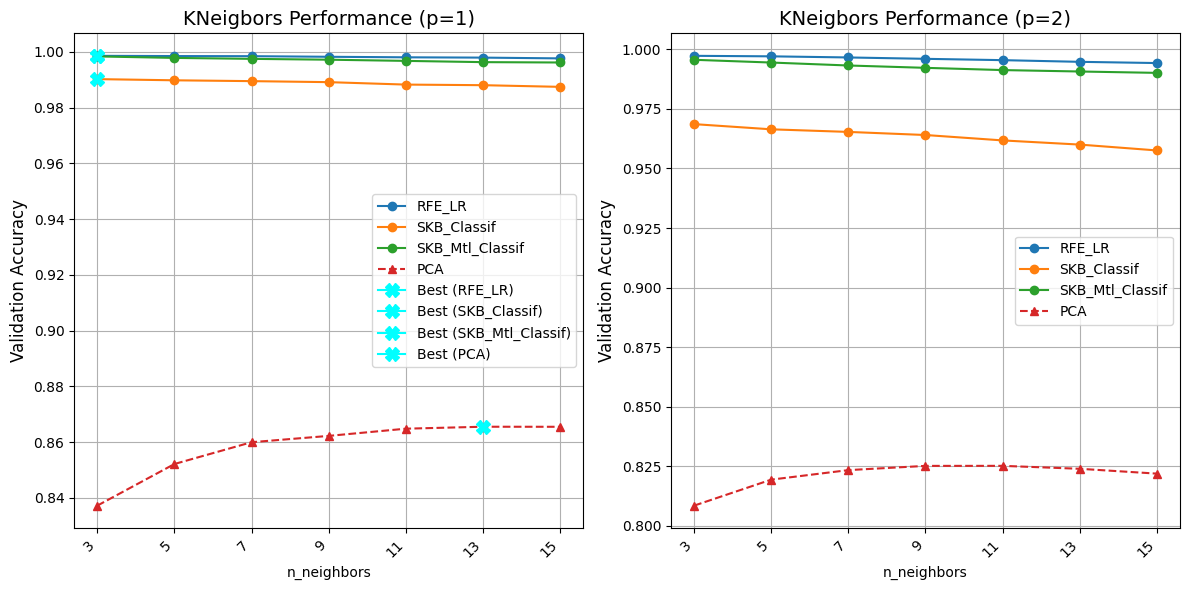

In [32]:
combined_results_knn_df['param_combination'] = (
    combined_results_knn_df['param_n_neighbors'].astype(str) + " | " + combined_results_knn_df['param_p'].astype(str)
)
results_knn_p1 = combined_results_knn_df[combined_results_knn_df['param_p'] == 1].copy()
results_knn_p2 = combined_results_knn_df[combined_results_knn_df['param_p'] == 2].copy()

results_knn_p1['param_combination'] = results_knn_p1['param_combination'].apply(lambda x: x.split(' | ')[0])
results_knn_p2['param_combination'] = results_knn_p2['param_combination'].apply(lambda x: x.split(' | ')[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k in combined_results_knn_df['param_k'].unique():
    subset_all = combined_results_knn_df[combined_results_knn_df['param_k'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_p1 = results_knn_p1[results_knn_p1['param_k'] == k]
    if k == 'PCA':
        ax1.plot(subset_p1['param_combination'], subset_p1['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax1.plot(subset_p1['param_combination'], subset_p1['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_p'] == 1:
        ax1.plot(str(best_row['param_n_neighbors']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax1.set_title('KNeigbors Performance (p=1)', fontsize=14)
    ax1.set_xlabel('n_neighbors', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
    ax1.legend()
    ax1.grid(True)

    subset_p2 = results_knn_p2[results_knn_p2['param_k'] == k]
    if k == 'PCA':
        ax2.plot(subset_p2['param_combination'], subset_p2['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax2.plot(subset_p2['param_combination'], subset_p2['mean_test_accuracy'], marker='o', label=f'{k}')
    if best_row['param_p'] == 2:
        ax2.plot(str(best_row['param_n_neighbors']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax2.set_title('KNeigbors Performance (p=2)', fontsize=14)
    ax2.set_xlabel('n_neighbors', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()
plt.show()

In [33]:
combined_results_knn_df.to_csv('Final_Scripts/Final2/GS_KNN.csv', index=0)
test_metrics_knn_df.to_csv('Final_Scripts/Final2/Test_KNN.csv', index=0)